In [2]:
import numpy as np
import pandas as pd
import sklearn.linear_model as linear
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sb
import warnings
import missingno as msn
warnings.filterwarnings('ignore')

In [3]:
dhs_df = pd.read_csv("datasets/DHS_Data_By_Cell_with_Regression_Dat_AggregatedFoodGroups_27June2019.csv")

In [4]:
dhs_df.head()

,Cell_Order,fruits,Num_Households_Responded_fruits,vegetables,Num_Households_Responded_vegetables,dairy,Num_Households_Responded_dairy,eggs,Num_Households_Responded_eggs,meat_fish,...,Cons_kg.yr Eggs,"Cons_kg.yr Fish, Seafood",Cons_kg.yr Fruits - Excluding Wine,Cons_kg.yr Meat,Cons_kg.yr Milk - Excluding Butter,Cons_kg.yr Nuts_and_Seeds,Cons_kg.yr Pulses,Cons_kg.yr Starchy Roots,Cons_kg.yr Sugar & Sweeteners,Cons_kg.yr Vegetables
0,2158169,0.179487,13.0,0.494505,13.0,0.159341,13.0,0.346520,13.0,0.480220,...,17.324,15.084,52.856,51.040,156.888,2.434,1.542,135.794,47.558,154.956
1,2158170,0.227965,16.0,0.113839,16.0,0.353051,16.0,0.046875,16.0,0.280072,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622
2,2158171,0.166450,11.0,0.282359,11.0,0.319772,11.0,0.106585,11.0,0.136905,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622
3,2158173,0.321429,7.0,0.054945,7.0,0.877060,7.0,0.269231,7.0,0.153846,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622
4,2158174,0.207953,14.0,0.199923,14.0,0.190168,14.0,0.178890,14.0,0.086466,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622


### Preparing Dataset

In [9]:
# Merge with global data
production_df = pd.read_csv("datasets/production_avg_2011_2013.csv")
socio_economic_df = pd.read_csv("datasets/master.csv")

In [10]:
dhs_merged_df = dhs_df.merge(socio_economic_df, how="left", left_on= "ISO3C", right_on = "Country Code")
dhs_ml_df = dhs_merged_df.merge(production_df,how = "left",left_on = "ISO3C",right_on = "Code")

In [11]:
dhs_ml_df.columns

Index(['Cell_Order', 'fruits', 'Num_Households_Responded_fruits', 'vegetables',
       'Num_Households_Responded_vegetables', 'dairy',
       'Num_Households_Responded_dairy', 'eggs',
       'Num_Households_Responded_eggs', 'meat_fish',
       'Num_Households_Responded_meat_fish', 'nuts_pulses',
       'Num_Households_Responded_nuts_pulses', 'sweets',
       'Num_Households_Responded_sweets', 'grains_tubers',
       'Num_Households_Responded_grains_tubers', 'animal_source_foods',
       'Num_Households_Responded_animal_source_foods', 'Cell_Order.1', 'ISO3N',
       'Primary_Religion', 'Percent_Primary_Religion', 'Percent_Christian',
       'GDP_PPP_2015', 'GDP_PPP_2000', 'GDP_PPP_1990', 'Population_2015',
       'Population_2000', 'Population_1990', 'Travel_time_to_cities',
       'Soil_suit_overall', 'Soil_suit_cereals', 'Soil_suit_fruits',
       'Soil_suit_veges', 'Soil_suit_nuts_seeds', 'Soil_suit_pulses',
       'Soil_suit_roots', 'Soil_suit_chocolate', 'Soil_suit_coffee',
       

In [12]:
dhs_predictor_socio_cols = ['PerCapita_GDP_2015','agri_gdp_percentage(AVG from 2011 to 2013)',
                           'AVG GDP 2011-2013 Constant 2010']

dhs_predictor_consump_cols = ['Cons_kg.yr Cereals - Excluding Beer', 'Cons_kg.yr Eggs'
                        ,'Cons_kg.yr Fish, Seafood'
                       ,'Cons_kg.yr Meat', 'Cons_kg.yr Milk - Excluding Butter'
                       ,'Cons_kg.yr Nuts_and_Seeds', 'Cons_kg.yr Pulses'
                       ,'Cons_kg.yr Starchy Roots']

dhs_predictor_production_cols = ['Fish, Seafood', 'Bovine_Sheep_Pigmeat_Poultry', 'Milk_Egg', 'Cereals']
                    
dhs_predictor_other_cols = [ 'Primary_Religion', 'Travel_time_to_cities','Soil_suit_overall', 'Soil_suit_cereals']

dhs_outcome_cols = ['eggs','dairy','meat_fish','nuts_pulses','grains_tubers','animal_source_foods']


In [13]:
dhs_ml_final_df = dhs_ml_df[dhs_predictor_socio_cols + \
                      dhs_predictor_consump_cols + \
                      dhs_predictor_production_cols +\
                     dhs_predictor_other_cols +\
                        dhs_outcome_cols]



In [14]:
dhs_ml_final_df.head()

,PerCapita_GDP_2015,agri_gdp_percentage(AVG from 2011 to 2013),AVG GDP 2011-2013 Constant 2010,Cons_kg.yr Cereals - Excluding Beer,Cons_kg.yr Eggs,"Cons_kg.yr Fish, Seafood",Cons_kg.yr Meat,Cons_kg.yr Milk - Excluding Butter,Cons_kg.yr Nuts_and_Seeds,Cons_kg.yr Pulses,...,Primary_Religion,Travel_time_to_cities,Soil_suit_overall,Soil_suit_cereals,eggs,dairy,meat_fish,nuts_pulses,grains_tubers,animal_source_foods
0,16748.36,8.266235,1.440000e+11,140.708,17.324,15.084,51.040,156.888,2.434,1.542,...,Christians,82.41833,8.561080,8.491615,0.346520,0.159341,0.480220,0.159341,0.841392,0.986081
1,36616.53,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,Christians,74.77269,8.511680,8.491615,0.046875,0.353051,0.280072,0.074219,0.447915,0.679998
2,196970.70,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,Christians,96.45230,8.313398,8.491615,0.106585,0.319772,0.136905,0.150000,0.609615,0.563262
3,NaN,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,Christians,92.95013,7.087249,6.998866,0.269231,0.877060,0.153846,0.075549,0.756868,1.300137
4,NaN,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,Christians,104.31820,6.766561,6.492069,0.178890,0.190168,0.086466,0.182649,0.686842,0.455523


In [15]:
def overview(df):
    print("Datasets shape Rows:{} Columns:{}".format(df.shape[0],df.shape[1]))
    print("----------Number of Missing Values in Each Column------------")
    nan_series = df.isnull().sum(axis = 0)
    print(nan_series)
    print("-------------------------------------------------------------")
    nan_series_trun = df.isnull().sum(axis = 1)
    print("Number of rows with more than 2 missing values:{}".format(nan_series_trun[nan_series_trun > 2].shape))
    # Number of empty data in rows
    print("Number of rows with 0 missing values:{}".format(nan_series_trun[nan_series_trun == 0].shape))


In [16]:
# Merging New Dataset on Daily Protein Supply https://ourworldindata.org/food-per-person 

Datasets shape Rows:33636 Columns:25
----------Number of Missing Values in Each Column------------
PerCapita_GDP_2015                            23898
agri_gdp_percentage(AVG from 2011 to 2013)     1070
AVG GDP 2011-2013 Constant 2010                1070
Cons_kg.yr Cereals - Excluding Beer            1767
Cons_kg.yr Eggs                                1767
Cons_kg.yr Fish, Seafood                       1767
Cons_kg.yr Meat                                1767
Cons_kg.yr Milk - Excluding Butter             1767
Cons_kg.yr Nuts_and_Seeds                      1767
Cons_kg.yr Pulses                              1776
Cons_kg.yr Starchy Roots                       1767
Fish, Seafood                                  1778
Bovine_Sheep_Pigmeat_Poultry                   1778
Milk_Egg                                       1778
Cereals                                        1778
Primary_Religion                                845
Travel_time_to_cities                           709
Soil_suit_overall

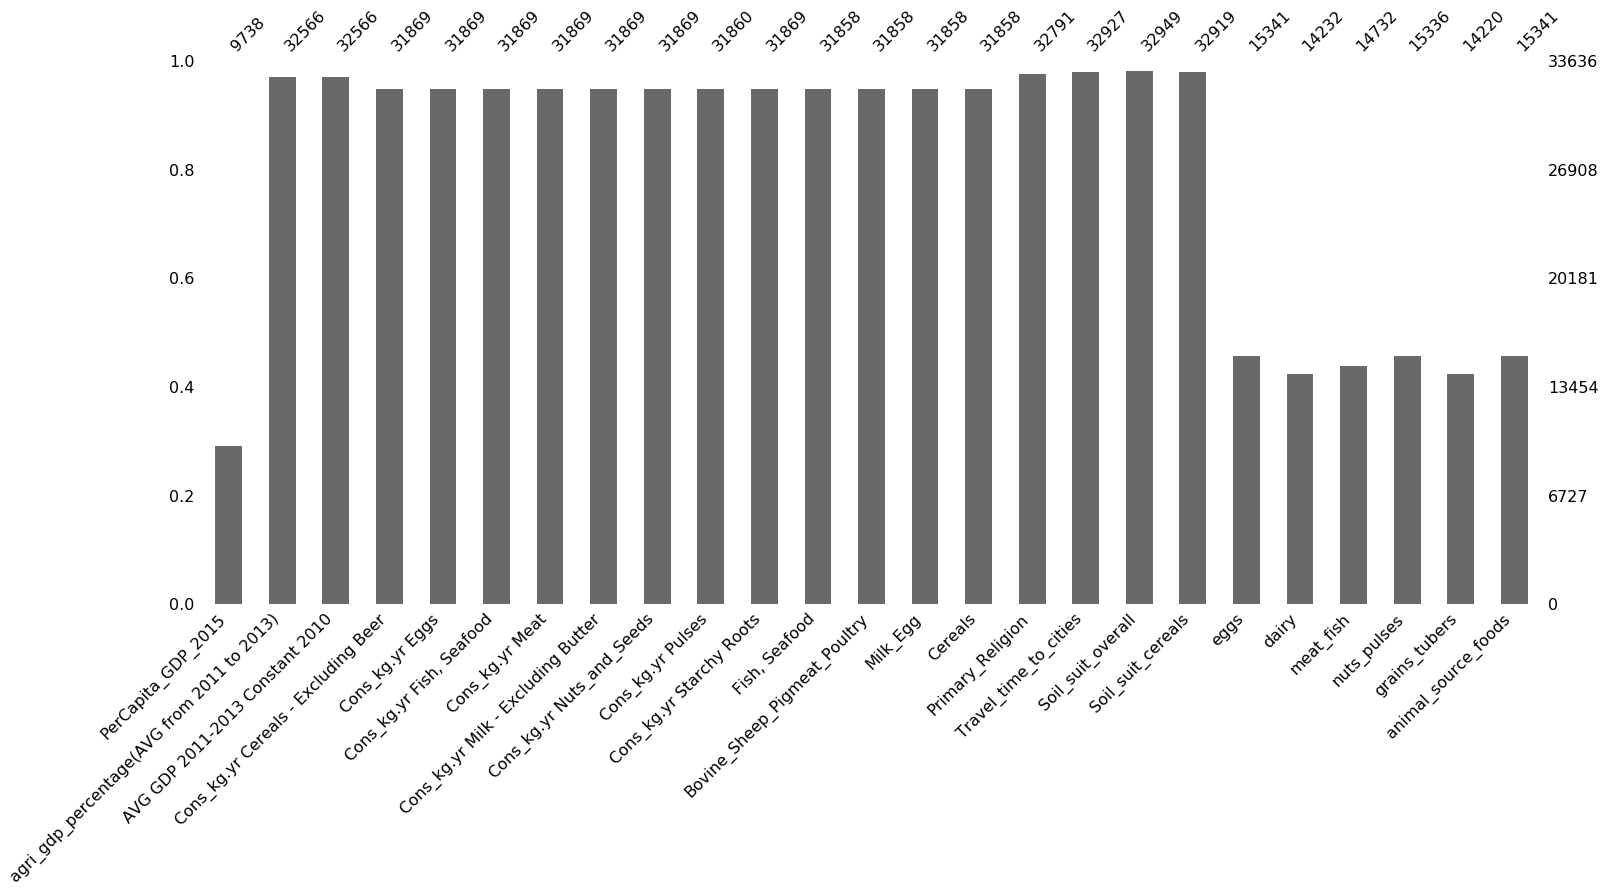

In [17]:
overview(dhs_ml_final_df)
msn.bar(dhs_ml_final_df)

In [18]:
# Describe the df for later binning 
dhs_ml_final_df.describe()

,PerCapita_GDP_2015,agri_gdp_percentage(AVG from 2011 to 2013),AVG GDP 2011-2013 Constant 2010,Cons_kg.yr Cereals - Excluding Beer,Cons_kg.yr Eggs,"Cons_kg.yr Fish, Seafood",Cons_kg.yr Meat,Cons_kg.yr Milk - Excluding Butter,Cons_kg.yr Nuts_and_Seeds,Cons_kg.yr Pulses,...,Cereals,Travel_time_to_cities,Soil_suit_overall,Soil_suit_cereals,eggs,dairy,meat_fish,nuts_pulses,grains_tubers,animal_source_foods
count,9.738000e+03,32566.000000,3.256600e+04,31869.000000,31869.000000,31869.000000,31869.000000,31869.000000,31869.000000,31860.000000,...,31858.000000,32927.000000,32949.000000,32919.000000,15341.000000,14232.000000,14732.000000,15336.000000,14220.000000,15341.000000
mean,6.297845e+05,18.178100,9.072301e+11,144.706748,2.946221,9.119134,15.431158,60.466107,7.485483,10.159290,...,140216.774175,84.577865,3.689815,4.847131,0.179699,0.307544,0.214144,0.214951,0.771722,0.660698
std,4.229339e+07,9.091649,8.924257e+11,30.463388,2.694458,9.443972,15.944532,41.707157,4.753144,5.415579,...,136470.677345,182.112694,2.446254,1.706133,0.180273,0.292596,0.180770,0.196895,0.307020,0.427364
min,3.708221e-01,1.364670,9.170050e+08,45.702000,0.230000,0.070000,4.066000,2.764000,0.004000,0.002000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.246027e+03,13.700025,2.292143e+10,131.332000,1.868000,5.250000,4.246000,30.498000,4.804000,6.698000,...,7707.000000,15.275455,1.526093,3.683363,0.055385,0.125000,0.081245,0.085714,0.607504,0.400602
50%,5.548771e+03,17.061925,3.200000e+11,151.158000,2.012000,5.250000,8.174000,69.348000,7.328000,11.668000,...,45106.333333,36.820080,4.078951,4.945596,0.142857,0.250000,0.201033,0.172891,0.752357,0.621679
75%,1.734346e+04,18.852912,1.870000e+12,151.158000,2.820000,7.790000,20.950000,69.348000,7.328000,11.668000,...,286672.000000,89.207445,5.744786,5.965656,0.246154,0.400000,0.305839,0.285714,0.916667,0.838776
max,4.147370e+09,52.047069,7.200000e+12,257.928000,18.566000,52.438000,97.278000,336.916000,31.880000,35.386000,...,638749.666667,4653.946000,8.809972,8.998034,1.000000,3.000000,2.000000,1.000000,2.000000,6.000000


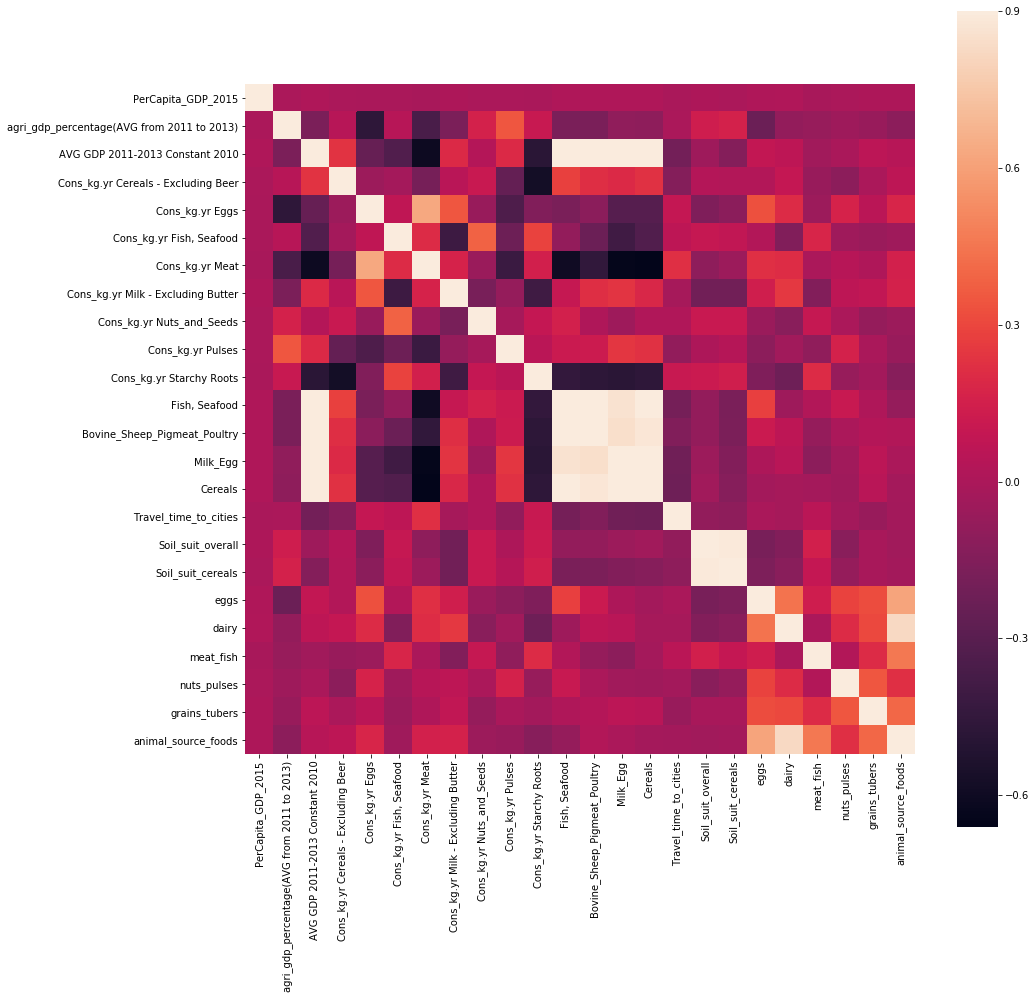

In [19]:
dhs_ml_final_df_mat = dhs_ml_final_df.corr()
dhs_ml_final_df_fig = plt.figure(figsize = (15,15))
sb.heatmap(dhs_ml_final_df_mat, vmax = .9, square = True)

In [20]:


def separate_training_testing(myData):
    """
    This function seperates the training sets and validation sets.
    """
    valueArray = myData.values
    X = valueArray[:, 0:myData.shape[1] - 1]
    Y = valueArray[:, myData.shape[1] - 1]
    test_size = 0.25
    seed = 7
    X_train, X_validate, Y_train, Y_validate = train_test_split(X, Y, test_size=test_size, random_state=seed)
    return X_train, X_validate, Y_train, Y_validate


In [22]:
# Check if there is any low variance 
# Code from https://www.programcreek.com/python/example/93973/sklearn.feature_selection.VarianceThreshold
def feature_select(df):
    x_train, x_test, y_train, y_test = separate_training_testing(df)
    selector = VarianceThreshold()
    selector.fit(x_train, y_train)

    # Retain the feature names
    features = selector.get_support(indices = True)  # Returns array of indexes of nonremoved features
#     features = [column for column in df[features] if column != target]  # Gets feature names
    print(features)

In [23]:
feature_select(dhs_ml_final_df_mat)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


### Machine Learning 

In [24]:
def string_to_int(df, col_name):
    """
    This is a helper function for converting the string labels to numerical
    """
    m = {}
    for i,e in enumerate(df[col_name].unique()):
        m.update({e: i})
    return m

In [35]:
def create_bins_width(df, col_name, bin_width):
    """
    This function cuts bins using equal width method
    """
    max = df[col_name].max()
    min = df[col_name].min()
    bins = np.arange(min, max, bin_width)
    print('This cuts the {} array into {} bins in equal width'.format(col_name,len(bins)))
    new_col_name = col_name + "_group"
    df[new_col_name] = np.digitize(df[col_name], bins)
    return df


def create_bins_depth(df, col_name, bin_num):
    """
    This function cuts bins using equal depth method
    """
    new_col_name = col_name + " group"
    df[new_col_name],bins= pd.qcut(df[col_name],bin_num, retbins=True, labels=list(range(bin_num)))
    print('This cuts the {} array into {} result in {} bins in equal depth'.format(col_name,bins,bin_num))
    df[new_col_name] = df[new_col_name].astype(int)
    df = df.drop(col_name, axis=1)
    return df 

In [39]:
def clean_data(df):
    #   Making an assumption here that NA religion is no religion. 
    df["Primary_Religion"] = df["Primary_Religion"].fillna("No Religion")
    
    result_df = df.dropna()
    
    m = string_to_int(result_df, "Primary_Religion")
    result_df["Primary_Religion"] = result_df["Primary_Religion"].map(m)
    create_bins_width(result_df,"Travel_time_to_cities",10)
    create_bins_width(result_df,"Soil_suit_overall",2)
    create_bins_width(result_df,"Soil_suit_cereals",2)
    
    for c in dhs_predictor_consump_cols:
        result_df = create_bins_width(result_df,c,30)
    
    for p in dhs_predictor_production_cols:
        result_df = create_bins_width(result_df,p,100)
        
    result_df["agri_gdp_percentage(AVG from 2011 to 2013)"].astype(float,inplace = True)
    result_df["AVG GDP 2011-2013 Constant 2010"].astype(float,inplace = True)
    
    create_bins_width(result_df,"PerCapita_GDP_2015",1000)
    
    create_bins_width(result_df,"agri_gdp_percentage(AVG from 2011 to 2013)",5)
    create_bins_width(result_df,"AVG GDP 2011-2013 Constant 2010",1000000)
    
        
    for i in dhs_outcome_cols:
        # We bin our outcome variables all into 4 cats. 
        if i == "eggs" or i == "nuts_pulses":
            result_df = create_bins_width(result_df,i,0.25)
        else:
            result_df = create_bins_width(result_df,i,0.5)
        
#     df = df.drop(['Code','Entity'], axis=1)
    result_df.to_csv('datasets/binned_grouped_diet.csv')
    return result_df

In [42]:

desired_cols = dhs_predictor_socio_cols + \
                      dhs_predictor_consump_cols + \
                      dhs_predictor_production_cols +\
                     dhs_predictor_other_cols 

desired_group_cols = [i+"_group" for i in desired_cols]
desired_group_cols.remove('Primary_Religion_group')
cleaned_dhs_df = clean_data(dhs_ml_final_df)


This cuts the Travel_time_to_cities array into 268 bins in equal width
This cuts the Soil_suit_overall array into 5 bins in equal width
This cuts the Soil_suit_cereals array into 5 bins in equal width
This cuts the Cons_kg.yr Cereals - Excluding Beer array into 8 bins in equal width
This cuts the Cons_kg.yr Eggs array into 1 bins in equal width
This cuts the Cons_kg.yr Fish, Seafood array into 2 bins in equal width
This cuts the Cons_kg.yr Meat array into 4 bins in equal width
This cuts the Cons_kg.yr Milk - Excluding Butter array into 12 bins in equal width
This cuts the Cons_kg.yr Nuts_and_Seeds array into 2 bins in equal width
This cuts the Cons_kg.yr Pulses array into 2 bins in equal width
This cuts the Cons_kg.yr Starchy Roots array into 14 bins in equal width
This cuts the Fish, Seafood array into 568 bins in equal width
This cuts the Bovine_Sheep_Pigmeat_Poultry array into 810 bins in equal width
This cuts the Milk_Egg array into 1357 bins in equal width
This cuts the Cereals ar

In [43]:
def draw_roc_curve(name, model, X_validate, Y_validate):
    """
    This functions draws ROC graphs.
    """
    predicted_probas = model.predict_proba(X_validate)
    skplt.metrics.plot_roc(Y_validate, predicted_probas, title = "Roc Curve of {}".format(name))
    plt.show()
    # uncomment here to save the plots
    # plt.savefig(name)


def plot_confusion_matrix(Y_pred, Y_validate, name, out_come):
    """
    This function plots the confusion matrix.
    """

    skplt.metrics.plot_confusion_matrix(Y_validate, Y_pred,title = "Predicting {} Using {} Confusion Matrix".format(out_come, name))
    plt.show()
    # uncomment here to save the plots(Included in the write-up)
    # plt.savefig("cnf_matrix " + name)


def model_evaluate(X_train, X_validate, Y_train, Y_validate, num_folds, num_instances, seed, scoring, models, out_come):
    """
    This function handles evaluation of machine learning methods using cross validation 
    """
    results = []
    for name, model in models:

        # Get a prediction
        trained_model = model.fit(X_train, Y_train)
            
        Y_pred = trained_model.predict(X_validate)
        
        # Plot the condusion matrix and Roc curve
        plot_confusion_matrix(Y_pred, Y_validate, name, out_come)
#         draw_roc_curve(name, trained_model, X_validate, Y_validate)
        print("Predicting {} Using {} Accuracy is {}".format(out_come,name,accuracy_score(Y_validate,Y_pred)))
        # Evalutate out models 
        kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=False)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        msg = "Predicting {} Using {} model's accuracy is {}, with a standard deviation of {}".format(out_come, name, cv_results.mean(), cv_results.std())
        print(msg)
                
def perform_ml(df,out_come):
    """
    This function is the driver code for this machine learning prediction
    Args:
        bin_class: A boolean variable decides if we bin our label(MMD) or not. 
    """
    models = [('KNN', KNeighborsClassifier()), ('CART', DecisionTreeClassifier()),
                    ('RFC', RandomForestClassifier()), ('NB', GaussianNB()),('MLP', MLPClassifier(solver='sgd', alpha=1e-5
                    ,hidden_layer_sizes=(50, 3), random_state=1))
#                     ,('SVM', svm.SVC(gamma=0.001, decision_function_shape='ovo', probability=True))
             ]
    
#     models = [('RFC', RandomForestClassifier())]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', models, out_come)

In [44]:

cleaned_dhs_eggs_df = cleaned_dhs_df[desired_group_cols + ["eggs_group"]]

cleaned_dhs_eggs_df.head()

,PerCapita_GDP_2015_group,agri_gdp_percentage(AVG from 2011 to 2013)_group,AVG GDP 2011-2013 Constant 2010_group,Cons_kg.yr Cereals - Excluding Beer_group,Cons_kg.yr Eggs_group,"Cons_kg.yr Fish, Seafood_group",Cons_kg.yr Meat_group,Cons_kg.yr Milk - Excluding Butter_group,Cons_kg.yr Nuts_and_Seeds_group,Cons_kg.yr Pulses_group,Cons_kg.yr Starchy Roots_group,"Fish, Seafood_group",Bovine_Sheep_Pigmeat_Poultry_group,Milk_Egg_group,Cereals_group,Travel_time_to_cities_group,Soil_suit_overall_group,Soil_suit_cereals_group,eggs_group
0,17,2,141656,4,1,1,2,6,1,1,5,3,23,125,769,9,5,5,2
1,37,2,5229,4,1,1,2,6,1,1,2,1,2,6,22,8,5,5,1
2,197,2,5229,4,1,1,2,6,1,1,2,1,2,6,22,10,5,5,1
5,3,2,141656,4,1,1,2,6,1,1,5,3,23,125,769,6,5,5,1
6,5,2,141656,4,1,1,2,6,1,1,5,3,23,125,769,9,5,5,1


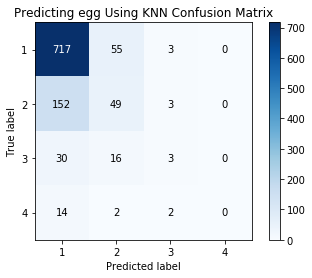

Predicting egg Using KNN Accuracy is 0.7351816443594646
Predicting egg Using KNN model's accuracy is 0.7310463767526099, with a standard deviation of 0.028922263302472228


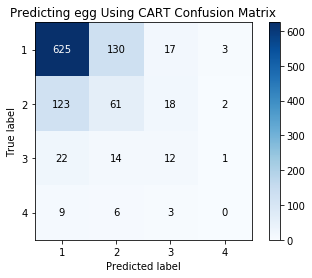

Predicting egg Using CART Accuracy is 0.6673040152963671
Predicting egg Using CART model's accuracy is 0.647881605990924, with a standard deviation of 0.030507513638631245


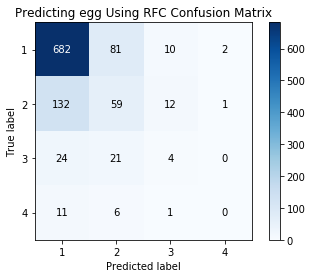

Predicting egg Using RFC Accuracy is 0.7122370936902486
Predicting egg Using RFC model's accuracy is 0.6953572373374575, with a standard deviation of 0.030499781634084268


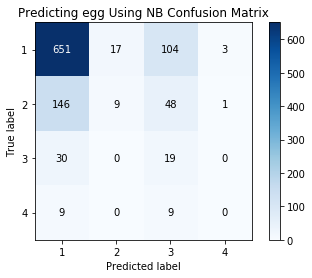

Predicting egg Using NB Accuracy is 0.6491395793499044
Predicting egg Using NB model's accuracy is 0.5746281109460531, with a standard deviation of 0.14066236439768895


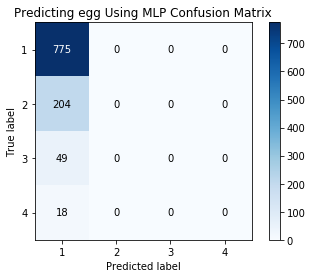

Predicting egg Using MLP Accuracy is 0.7409177820267686
Predicting egg Using MLP model's accuracy is 0.7469831708756436, with a standard deviation of 0.02804325440670299


In [45]:
perform_ml(cleaned_dhs_eggs_df,"egg")

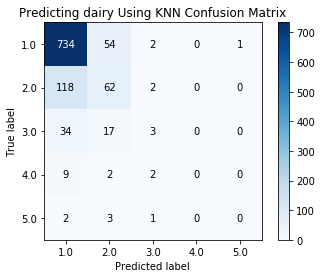

Predicting dairy Using KNN Accuracy is 0.7638623326959847
Predicting dairy Using KNN model's accuracy is 0.7533648073909769, with a standard deviation of 0.027401856255994877


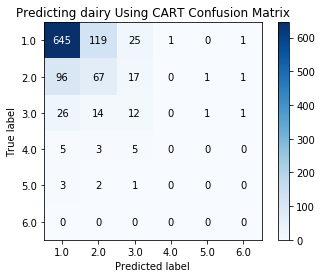

Predicting dairy Using CART Accuracy is 0.6921606118546845
Predicting dairy Using CART model's accuracy is 0.6963075639486375, with a standard deviation of 0.021067857631062618


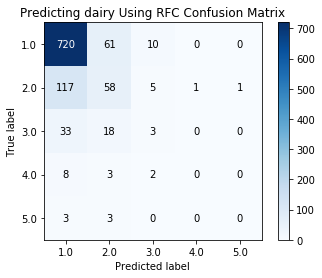

Predicting dairy Using RFC Accuracy is 0.7466539196940727
Predicting dairy Using RFC model's accuracy is 0.7625933538186036, with a standard deviation of 0.020538865133891627


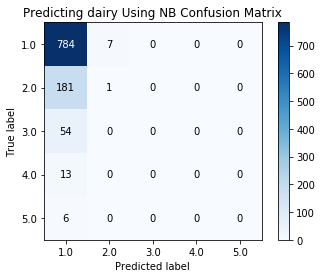

Predicting dairy Using NB Accuracy is 0.7504780114722753
Predicting dairy Using NB model's accuracy is 0.7645143566471988, with a standard deviation of 0.022892011386249814


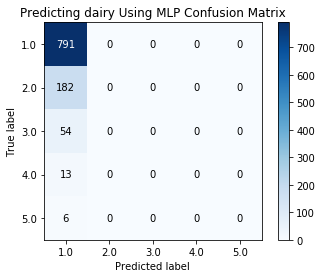

Predicting dairy Using MLP Accuracy is 0.7562141491395793
Predicting dairy Using MLP model's accuracy is 0.7708858183594147, with a standard deviation of 0.022601183598001343


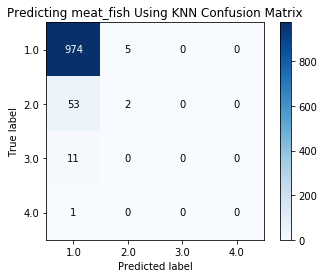

Predicting meat_fish Using KNN Accuracy is 0.9330783938814532
Predicting meat_fish Using KNN model's accuracy is 0.9311694918703323, with a standard deviation of 0.006977182038862064


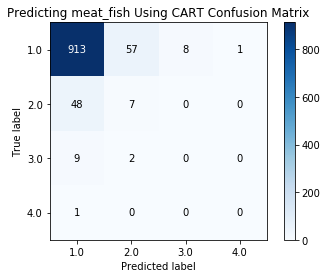

Predicting meat_fish Using CART Accuracy is 0.8795411089866156
Predicting meat_fish Using CART model's accuracy is 0.8843308031989581, with a standard deviation of 0.017851809533399998


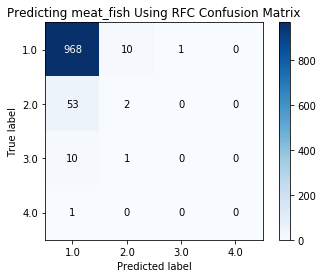

Predicting meat_fish Using RFC Accuracy is 0.9273422562141491
Predicting meat_fish Using RFC model's accuracy is 0.9279786736126654, with a standard deviation of 0.00519190443479307


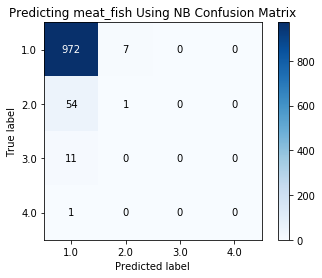

Predicting meat_fish Using NB Accuracy is 0.9302103250478011
Predicting meat_fish Using NB model's accuracy is 0.9235221098471745, with a standard deviation of 0.014151226643925714


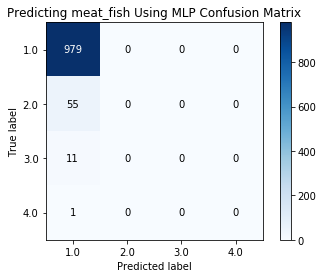

Predicting meat_fish Using MLP Accuracy is 0.9359464627151052
Predicting meat_fish Using MLP model's accuracy is 0.9356280905964469, with a standard deviation of 0.005833801605636219


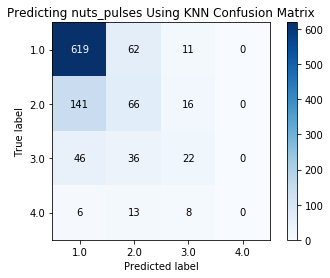

Predicting nuts_pulses Using KNN Accuracy is 0.6759082217973231
Predicting nuts_pulses Using KNN model's accuracy is 0.6539335788852486, with a standard deviation of 0.03666735021355406


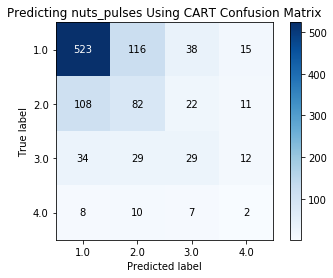

Predicting nuts_pulses Using CART Accuracy is 0.6080305927342257
Predicting nuts_pulses Using CART model's accuracy is 0.574583341812336, with a standard deviation of 0.037643498626029885


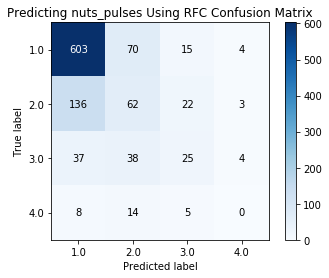

Predicting nuts_pulses Using RFC Accuracy is 0.6596558317399618
Predicting nuts_pulses Using RFC model's accuracy is 0.6475590647320975, with a standard deviation of 0.029116292478345893


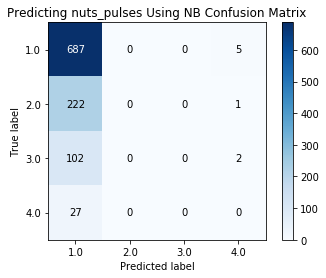

Predicting nuts_pulses Using NB Accuracy is 0.6567877629063098
Predicting nuts_pulses Using NB model's accuracy is 0.6469302618994321, with a standard deviation of 0.027766723103661024


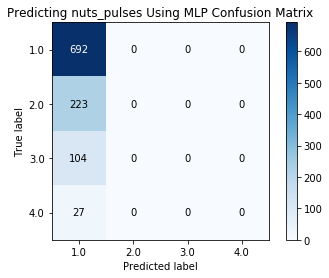

Predicting nuts_pulses Using MLP Accuracy is 0.6615678776290631
Predicting nuts_pulses Using MLP model's accuracy is 0.6513919130664823, with a standard deviation of 0.02951830559324598


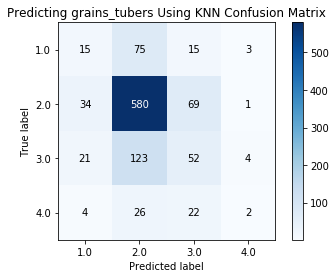

Predicting grains_tubers Using KNN Accuracy is 0.6204588910133844
Predicting grains_tubers Using KNN model's accuracy is 0.6089914735149875, with a standard deviation of 0.024267754152700133


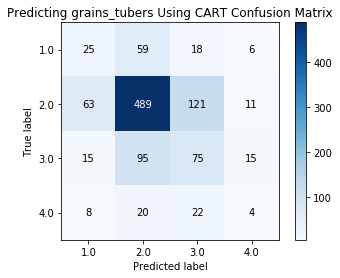

Predicting grains_tubers Using CART Accuracy is 0.5669216061185468
Predicting grains_tubers Using CART model's accuracy is 0.5650251317637004, with a standard deviation of 0.03275798549818394


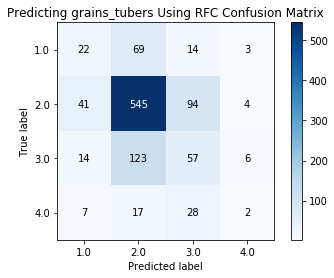

Predicting grains_tubers Using RFC Accuracy is 0.5984703632887189
Predicting grains_tubers Using RFC model's accuracy is 0.6281119635335056, with a standard deviation of 0.02810569547417913


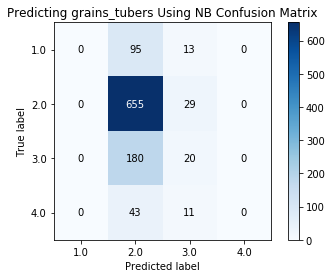

Predicting grains_tubers Using NB Accuracy is 0.6453154875717018
Predicting grains_tubers Using NB model's accuracy is 0.6523229075517388, with a standard deviation of 0.01670552658083181


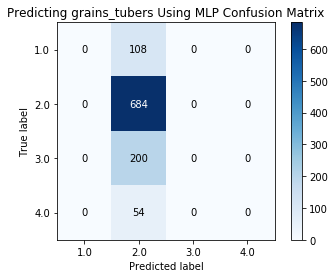

Predicting grains_tubers Using MLP Accuracy is 0.6539196940726577
Predicting grains_tubers Using MLP model's accuracy is 0.6545593292769785, with a standard deviation of 0.017288195501165216


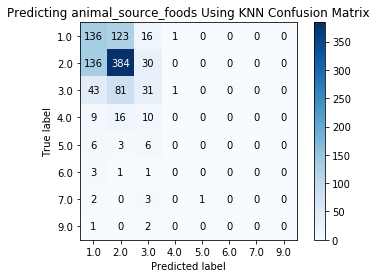

Predicting animal_source_foods Using KNN Accuracy is 0.5267686424474187
Predicting animal_source_foods Using KNN model's accuracy is 0.5248804460633687, with a standard deviation of 0.03297896201887519


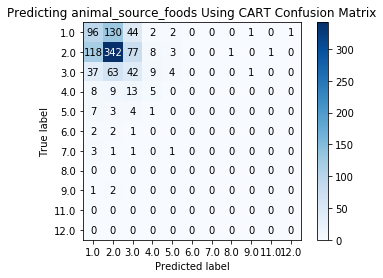

Predicting animal_source_foods Using CART Accuracy is 0.46367112810707456
Predicting animal_source_foods Using CART model's accuracy is 0.4694135243483039, with a standard deviation of 0.03925714909212603


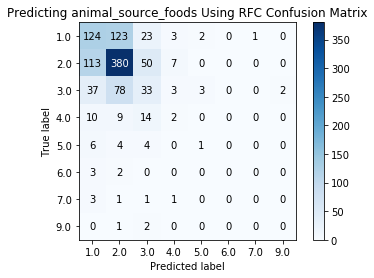

Predicting animal_source_foods Using RFC Accuracy is 0.5162523900573613
Predicting animal_source_foods Using RFC model's accuracy is 0.5226185873303352, with a standard deviation of 0.0333157306028206


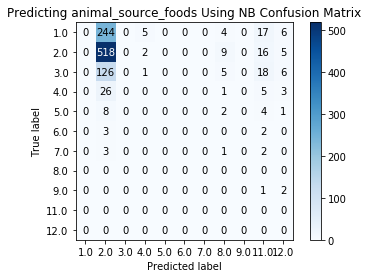

Predicting animal_source_foods Using NB Accuracy is 0.49521988527724664
Predicting animal_source_foods Using NB model's accuracy is 0.49523513970004684, with a standard deviation of 0.023395305635599984


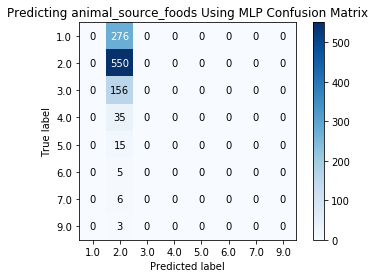

Predicting animal_source_foods Using MLP Accuracy is 0.5258126195028681
Predicting animal_source_foods Using MLP model's accuracy is 0.528689892350583, with a standard deviation of 0.020148927599711226


In [46]:
# Try it with all others! 
for out_come in dhs_outcome_cols:
    if out_come != "eggs":
        ml_df = cleaned_dhs_df[dhs_predictor_socio_cols + \
                      dhs_predictor_consump_cols + \
                      dhs_predictor_production_cols +\
                               dhs_predictor_other_cols + ["{}_{}".format(out_come,"group")]]
        perform_ml(ml_df,out_come)


#### Try a few Machine Learning Improving Methods 

1) Boosting 
2) Bagging 

### Global Dietary Database

In [45]:
gdd_merged_socio_df = global_dietary_database_2010_df.merge(socio_economic_df, how="left", left_on= "iso3", right_on = "Country Code")
gdd_merged_df = gdd_merged_socio_df.merge(production_df,how = "left",left_on = "iso3",right_on = "Code")

In [46]:
gdd_merged_df.head()

,year,superregion2,iso3,countryname,female,age,urban,edu,v01_wt_median,v01_lowerci_95,...,Code,Continent,Crop as Prop total,Pasture as prop total area,principal component 1,principal component 2,Continent_Cluster,Bovine_Sheep_Pigmeat_Poultry,Milk_Egg,Cereals
0,2010,MENA,AFG,Afghanistan,0,2,0,1,61.430199,33.386585,...,AFG,Asia,0.123556,0.417267,-0.542152,-0.328127,0.0,318.0,1825.333333,5970.333333
1,2010,MENA,AFG,Afghanistan,0,2,0,2,77.183182,41.668953,...,AFG,Asia,0.123556,0.417267,-0.542152,-0.328127,0.0,318.0,1825.333333,5970.333333
2,2010,MENA,AFG,Afghanistan,0,2,0,3,93.592743,52.055630,...,AFG,Asia,0.123556,0.417267,-0.542152,-0.328127,0.0,318.0,1825.333333,5970.333333
3,2010,MENA,AFG,Afghanistan,0,2,0,999,69.622902,NaN,...,AFG,Asia,0.123556,0.417267,-0.542152,-0.328127,0.0,318.0,1825.333333,5970.333333
4,2010,MENA,AFG,Afghanistan,0,2,1,1,71.706451,37.763165,...,AFG,Asia,0.123556,0.417267,-0.542152,-0.328127,0.0,318.0,1825.333333,5970.333333


In [48]:
# Prepare our dataset for it. 
gdd_merged_df.columns

Index(['year', 'superregion2', 'iso3', 'countryname', 'female', 'age', 'urban',
       'edu', 'v01_wt_median', 'v01_lowerci_95', 'v01_upperci_95',
       'v02_wt_median', 'v02_lowerci_95', 'v02_upperci_95', 'v05_wt_median',
       'v05_lowerci_95', 'v05_upperci_95', 'v06_wt_median', 'v06_lowerci_95',
       'v06_upperci_95', 'v10_wt_median', 'v10_lowerci_95', 'v10_upperci_95',
       'v15_wt_median', 'v15_lowerci_95', 'v15_upperci_95', 'v16_wt_median',
       'v16_lowerci_95', 'v16_upperci_95', 'v23_wt_median', 'v23_lowerci_95',
       'v23_upperci_95', 'v36_wt_median', 'v36_lowerci_95', 'v36_upperci_95',
       'v37_wt_median', 'v37_lowerci_95', 'v37_upperci_95', 'v41_wt_median',
       'v41_lowerci_95', 'v41_upperci_95', 'v57_wt_median', 'v57_lowerci_95',
       'v57_upperci_95', 'Country Name', 'Country Code',
       'Gini Avg 2011 to 2013',
       'Gini Flag(Selecing whichever is the closest, if two values with equal distance to 2012. Average)',
       'ari_employment value (AVG 20

In [75]:

columns_to_use = ['iso3','female', 'age', 'urban','edu'
                  , 'agri_gdp_percentage(AVG from 2011 to 2013)'
                 ,'Fish, Seafood','Bovine_Sheep_Pigmeat_Poultry'
                  ,'Unemployment(AVG 2011 to 2013)'
                  ,'AVG GDP 2011-2013 Constant 2010'
                  ,'Milk_Egg', 'Cereals','v23_wt_median']
gdd_ml_df = gdd_merged_df[columns_to_use]
# gdd_ml_df = gdd_ml_df.rename({"agri_gdp_percentage(AVG from 2011 to 2013)":"agri_gdp","AVG GDP 2011-2013 Constant 2010":"gdp"},axis=1)
gdd_ml_df['AVG GDP 2011-2013 Constant 2010'].astype(float,inplace = True)
gdd_ml_df['agri_gdp_percentage(AVG from 2011 to 2013)'].astype(float,inplace = True)
gdd_ml_df.head()

,iso3,female,age,urban,edu,agri_gdp_percentage(AVG from 2011 to 2013),"Fish, Seafood",Bovine_Sheep_Pigmeat_Poultry,AVG GDP 2011-2013 Constant 2010,Milk_Egg,Cereals,v23_wt_median
0,AFG,0,2,0,1,23.64840012,2.0,318.0,17613180372,1825.333333,5970.333333,49.122440
1,AFG,0,2,0,2,23.64840012,2.0,318.0,17613180372,1825.333333,5970.333333,51.246414
2,AFG,0,2,0,3,23.64840012,2.0,318.0,17613180372,1825.333333,5970.333333,51.346333
3,AFG,0,2,0,999,23.64840012,2.0,318.0,17613180372,1825.333333,5970.333333,49.898979
4,AFG,0,2,1,1,23.64840012,2.0,318.0,17613180372,1825.333333,5970.333333,49.553265


In [76]:
print(gdd_ml_df[gdd_ml_df["female"] == 999].shape[0])
print(gdd_ml_df[gdd_ml_df["edu"] == 999].shape[0])
print(gdd_ml_df[gdd_ml_df["urban"] == 999].shape[0])

47124
35343
47124


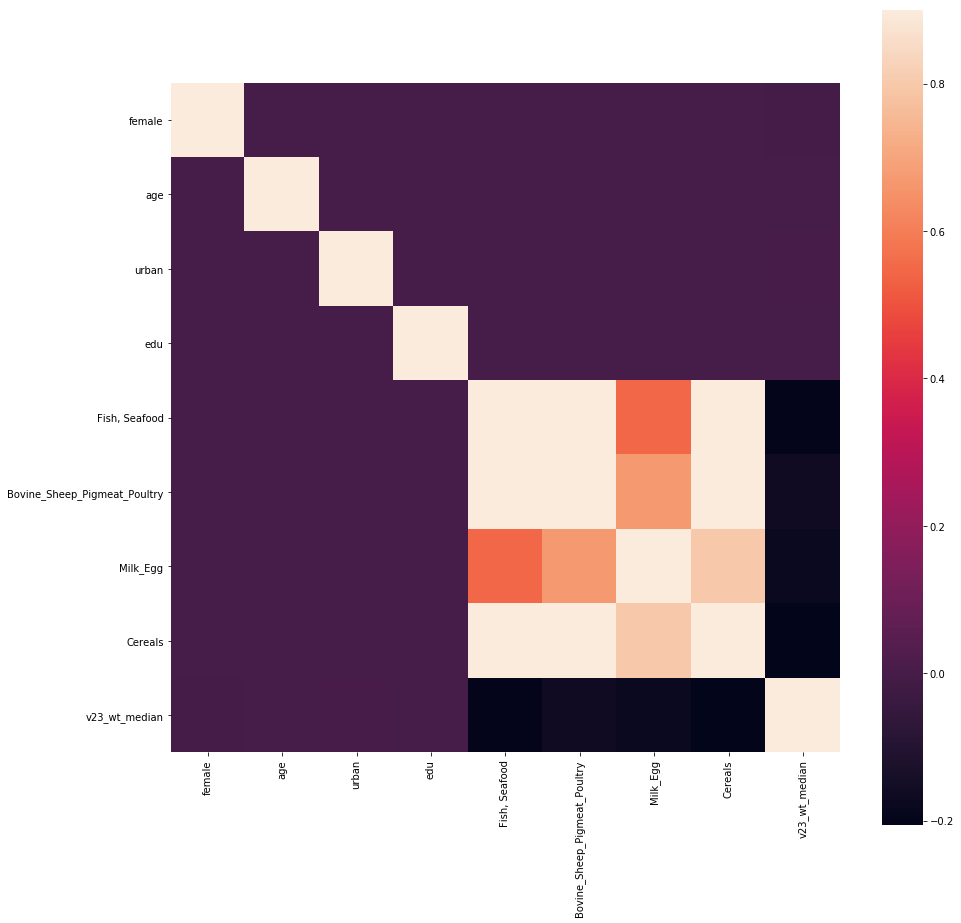

In [77]:
# Try a heat map before we proceed
gdd_mat = gdd_ml_df.corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(gdd_mat, vmax = .9, square = True)



In [85]:
# Clean our dataset. Some columns has 999 which is not usable. 
gdd_ml_cleaned_df = gdd_ml_df[(gdd_ml_df["female"] != 999)&(gdd_ml_df["age"] != 999)&(gdd_ml_df["urban"] != 999)&(gdd_ml_df["edu"] != 999)]

In [86]:
gdd_ml_cleaned_df.shape[0]

44880